## Bank Marketing Exercise

Use the bank direct marketing dataset (bank.csv) to 

- train a logistic regression (sklearn) predicting if a client will subscribe (1/0) to a term deposit (variable called ‘y’).

- Use a train and test setup and use k-fold cross-validation to choose between L1- and L2-penalty or no penalty (read the documentation of sklearn.linear_model.LogisticRegression, you will have to specify ‘penalty’ and ‘C’). Hint: Use class_weight = ‘balanced’, as the dataset is unbalanced.

- Once you have chosen the best model (best test score), 

- plot the ROC curve as well as precision and recall 

- with varying thresholds (use the precision_recall_curve function from sklearn).

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, roc_curve
import sklearn.model_selection as skms 
import sklearn.preprocessing as skpp


In [2]:
data = pd.read_csv('/Users/iMotz/Propulsion/Machine_learning/data_sets/banking.csv')
data = pd.DataFrame(data)
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,...,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


### Data clean up and preparation

In [69]:
# explore data TYPES
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

#### 1. Split categorical and numerical columns and y (outcome)

In [4]:
cat_data = data.select_dtypes(include = ['object'])
cat_data.head(5)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,nonexistent
1,technician,married,unknown,no,no,no,cellular,nov,fri,nonexistent
2,management,single,university.degree,no,yes,no,cellular,jun,thu,success
3,services,married,high.school,no,no,no,cellular,apr,fri,nonexistent
4,retired,married,basic.4y,no,yes,no,cellular,aug,fri,success


In [5]:
y = data['y']

# check if output classes are balanced
subscribers = sum(y[y==1]) / len(y)
subscribers

0.11265417111780131

#### 2. Convert categorical columns into boolean:

In [6]:
# import encoder object
one_hot = skpp.OneHotEncoder()

# fit encoder
result = one_hot.fit(cat_data) # alt for specific cols: one_hot.fit(data[['col1', 'col2']])

# transform data set
cat_data_tf = result.transform(cat_data).toarray()
cat_data_tf

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [7]:
# convert to data frame

# extract col names:
col_names = one_hot.get_feature_names()
col_names.tolist()

df_cat_data = pd.DataFrame(columns = col_names.tolist(),data = cat_data_tf)
df_cat_data.head(5)

,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,...,x7_oct,x7_sep,x8_fri,x8_mon,x8_thu,x8_tue,x8_wed,x9_failure,x9_nonexistent,x9_success
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 3. Combine cat and num data, and split into test and train set

In [8]:
# select cols with numerical
num_data = data.select_dtypes(include = ['float64','int64'])
# drop outcome = y
num_data = num_data.drop(columns = ['y'])


In [9]:
# alt: pd.concat([df1, df2], axis = 1)

reun_data = pd.merge(df_cat_data, num_data, how = 'left', left_index = True, right_index = True)
reun_data.head(5)

,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,...,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2


In [10]:
# split data set
X_train, X_test, y_train, y_test = skms.train_test_split(reun_data, y, test_size = 0.2)


#### 4. Scale (z-score) numerical columns of X_test

In [11]:
# Normalise numerical Data: get the mean and std from TRAIN set, then use it on test set before prediction!
# use skpp.StandardScaler

# import scaler obj
scaler = skpp.StandardScaler()

# fit it to my NUMERICAL TRAIN data
# ACHTUNG: I dont have booleans, all are floats

# get num col names from original data
num_col_names = num_data.select_dtypes(include = ['float64','int64']).columns.tolist()

# use col names to index num cols
scaler.fit(X_train[num_col_names])

tr_num_train = scaler.transform(X_train[num_col_names])


/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/iMotz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [12]:
# convert into df
df_num_tf = pd.DataFrame(tr_num_train, columns = num_col_names)                        

# get cat df from X_train
df_cat_tf = X_train[col_names.tolist()].reset_index()

# merge
X_train_tf = pd.merge(df_num_tf, df_cat_tf, how = 'left', left_index = True, right_index = True)
                 
X_train_tf.head(5)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,x7_oct,x7_sep,x8_fri,x8_mon,x8_thu,x8_tue,x8_wed,x9_failure,x9_nonexistent,x9_success
0,0.288434,0.792486,-0.205404,0.194493,-0.348156,-1.206168,-1.184981,-1.232263,-1.378873,-0.949568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.096059,0.485273,-0.562012,0.194493,-0.348156,0.835913,1.538111,-0.280711,0.767133,0.843477,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.538873,-0.547733,-0.562012,0.194493,-0.348156,0.835913,0.590572,-0.475347,0.768288,0.843477,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.731249,0.658080,-0.562012,0.194493,-0.348156,-1.206168,-0.869712,-1.426899,-1.308957,-0.949568,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.192504,-0.517012,-0.562012,0.194493,-0.348156,-1.206168,-0.869712,-1.426899,-1.293356,-0.949568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Train model with L1 penalty (Lasso)

In [13]:
# log regress with inbuilt cross validation:

# LogisticRegressionCV(Cs=10, fit_intercept=True, cv=’warn’, dual=False, penalty=’l2’, 
#   scoring=None, solver=’lbfgs’, tol=0.0001, max_iter=100, class_weight=None, n_jobs=None, 
#   verbose=0, refit=True, intercept_scaling=1.0, multi_class=’warn’, random_state=None, l1_ratios=None)

# cv: fold cross validation
# scoring: 'balanced_accuracy': the average of recall obtained on each class, 0-1 (best)
#          'roc_auc': Compute Area Under the Receiver Operating Characteristic Curve, only for binary
# penalty: which type: l1 (Lasso), l2 (Ridge),..
# Cs: regularization. give list of values [0.1,1,10] and it will use them on all batches
# solver: 'liblinear' solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty
#         Elastic-Net penalty is only supported by the 'saga' solver


In [15]:
# fit 
my_Cs = [0.1, 1, 10]

regress_obj_L1 = lm.LogisticRegressionCV(cv = 5, 
                                         solver = 'liblinear', 
                                         fit_intercept = True, 
                                         scoring = 'roc_auc',
                                         max_iter = 1000, 
                                         penalty = 'l1', 
                                         Cs = my_Cs, 
                                         class_weight = 'balanced').fit(X_train_tf, y_train)


In [16]:
# show final mean score:
#score_L1 = regress_obj_L1.score(X_train_tf, y_train)
#score_L1

# get all separate scores:
array_scores_L1 = regress_obj_L1.scores_

# every col has the (cv=5) scores for one C value: I want the mean per C value
mean_L1_scores = np.mean(np.asmatrix(array_scores_L1[1]),0)

In [17]:
print('The mean balanced accuracy score of the model with penalty L1 and C = %.1f is: %.4f.' % (my_Cs[0],mean_L1_scores[0,0]))
print('The mean balanced accuracy score of the model with penalty L1 and C = %.1f is: %.4f.' % (my_Cs[1],mean_L1_scores[0,1]))
print('The mean balanced accuracy score of the model with penalty L1 and C = %.1f is: %.4f.' % (my_Cs[2],mean_L1_scores[0,2]))

The mean balanced accuracy score of the model with penalty L1 and C = 0.1 is: 0.9366.
The mean balanced accuracy score of the model with penalty L1 and C = 1.0 is: 0.9366.
The mean balanced accuracy score of the model with penalty L1 and C = 10.0 is: 0.9366.


### Train model with L2 penalty (Ridge)

In [30]:
# fit 
my_Cs = [0.1,1,10]

regress_obj_L2 = lm.LogisticRegressionCV(cv = 5, 
                                         solver = 'liblinear', 
                                         fit_intercept = True, 
                                         scoring = 'roc_auc',
                                         max_iter = 1000, 
                                         penalty = 'l2', 
                                         Cs = my_Cs, 
                                         class_weight = 'balanced').fit(X_train_tf, y_train)

regress_obj_L2_fit = regress_obj_L2



In [31]:
# get all separate scores:
array_scores_L2 = regress_obj_L2_fit.scores_

# every col has the (cv=5) scores for one C value: I want the mean per C value
mean_L2_scores = np.mean(np.asmatrix(array_scores_L2[1]),0)

In [32]:
print('The mean balanced accuracy score of the model with penalty L2 and C = %.1f is: %.4f.' % (my_Cs[0],mean_L2_scores[0,0]))
print('The mean balanced accuracy score of the model with penalty L2 and C = %.1f is: %.4f.' % (my_Cs[1],mean_L2_scores[0,1]))
print('The mean balanced accuracy score of the model with penalty L2 and C = %.1f is: %.4f.' % (my_Cs[2],mean_L2_scores[0,2]))

The mean balanced accuracy score of the model with penalty L2 and C = 0.1 is: 0.9365.
The mean balanced accuracy score of the model with penalty L2 and C = 1.0 is: 0.9366.
The mean balanced accuracy score of the model with penalty L2 and C = 10.0 is: 0.9366.


### Predict with best model:

In [33]:
# transform X_test before predict, use SAME scaler as for TRAIN set
tr_num_test = scaler.transform(X_test[num_col_names])

# convert into df
df_num_tf_test = pd.DataFrame(tr_num_test, columns = num_col_names)                        

# get cat df from X_train
df_cat_tf_test = X_test[col_names.tolist()].reset_index()

# merge
X_test_tf = pd.merge(df_num_tf_test, df_cat_tf_test, how = 'left', left_index = True, right_index = True)
                 
X_test_tf.head(5)


/Users/iMotz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,x7_oct,x7_sep,x8_fri,x8_mon,x8_thu,x8_tue,x8_wed,x9_failure,x9_nonexistent,x9_success
0,-0.577254,-0.735901,-0.562012,0.194493,-0.348156,-1.206168,-1.184981,-1.232263,-1.347093,-0.949568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.250567,-0.620696,0.507812,0.194493,-0.348156,0.835913,-0.230513,0.951981,0.770022,0.843477,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.731249,-0.010109,-0.562012,0.194493,-0.348156,-1.206168,-1.184981,-1.232263,-1.375406,-0.949568,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.096059,0.466072,-0.562012,0.194493,-0.348156,-1.206168,-1.184981,-1.232263,-1.378873,-0.949568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.384879,0.873130,-0.205404,0.194493,-0.348156,0.835913,-0.230513,0.951981,0.770022,0.843477,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [34]:
# predict test set
predicted_probs_L1 = regress_obj_L1.predict_proba(X_test_tf)[:,1]
predicted_probs_L2 = regress_obj_L2.predict_proba(X_test_tf)[:,1]


In [41]:
# predict training set 
predicted_probs_L1_train = regress_obj_L1.predict_proba(X_train_tf)[:,1]
predicted_probs_L2_train = regress_obj_L2.predict_proba(X_train_tf)[:,1]


In [46]:
# calculate true pos and false pos rate for L1
fpr_train, tpr_train, _ = roc_curve(y_train, predicted_probs_L1_train)
fpr_test, tpr_test, _ = roc_curve(y_test, predicted_probs_L1)

roc_df_train = pd.DataFrame({'fpr':fpr_train,'tpr':tpr_train})
roc_df_test = pd.DataFrame({'fpr':fpr_test, 'tpr':tpr_test})

In [61]:
# calculate true pos and false pos rate for L2
fpr_train_L2, tpr_train_L2, _ = roc_curve(y_train, predicted_probs_L2_train)
fpr_test_L2, tpr_test_L2, _ = roc_curve(y_test, predicted_probs_L2)

roc_df_train_L2 = pd.DataFrame({'fpr':fpr_train_L2,'tpr':tpr_train_L2})
roc_df_test_L2 = pd.DataFrame({'fpr':fpr_test_L2, 'tpr':tpr_test_L2})

In [62]:
roc_df_train.head(5)

,fpr,tpr
0,0.000000,0.000000
1,0.000034,0.000000
2,0.000068,0.000000
3,0.000068,0.000273
4,0.000102,0.000273


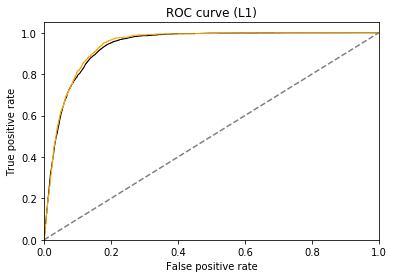

In [72]:
plt.plot(fpr_train, tpr_train, 'black', linewidth=1)
plt.plot(fpr_test, tpr_test, 'orange', linewidth=1)
plt.plot([0, 1], [0, 1],'grey', linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve (L1)')
None

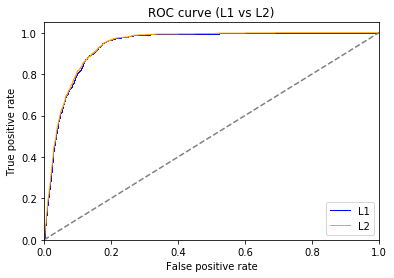

In [73]:
#plt.plot(fpr_train_L2, tpr_train_L2, 'black', linewidth=1)
plt.plot(fpr_test_L2, tpr_test_L2, 'blue', linewidth=1)
plt.plot(fpr_test, tpr_test, 'orange', linewidth=1)
plt.plot([0, 1], [0, 1],'grey', linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['L1','L2'], loc = 'lower right')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve (L1 vs L2)')
None
